In [1]:
# https://github.com/nalepae/bounding-box.git
# !pip install bounding-box
# !git clone https://github.com/nalepae/bounding-box.git
#!pip uninstall -y bounding-box

# Install segmentation package
#
!pip install -U segmentation-models-pytorch albumentations --user

#Install coco_utils
#!pip install cython
# Win10: follow this guide (Exactly!): https://github.com/philferriere/cocoapi
#       update: I fixed support for numpy > 1.17 due to error "'numpy.float64' object cannot be interpreted as an integer"
#       to include it use my git repo "pip install git+https://github.com/ofekp/cocoapi.git#subdirectory=PythonAPI"
#       make sure to remove the previous version befor einstalling from my branch by using "pip uninstall pycocotools"
# Colab/Linux:
#
!pip install -U git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

import torchvision
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import json
import math
import re
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import warnings
from sklearn import svm
from keras.datasets import fashion_mnist
import pandas as pd
import joblib
import os
import random
import time
import multiprocessing
from multiprocessing import Process, Pool, Queue, Lock, Value
import itertools
import pickle

current_time_millis = lambda: int(round(time.time() * 1000))

# imports for segmentation
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

warnings.filterwarnings('ignore')

is_colab = True

# connect to Google Drive
if is_colab:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/gdrive')
    print("Folder content:")
    main_folder_path = '/content/gdrive/Shared drives/project_200446375_204031231/'
    main_folder_path_escaped = main_folder_path.replace(" ", "\ ")
    !ls $main_folder_path_escaped
    ofek_code_folder_imports = '/content/gdrive/Shared drives/project_200446375_204031231/code_ofek/*.{py,ttf}'
    ofek_code_folder_imports = ofek_code_folder_imports.replace(" ", "\ ")
    !cp $ofek_code_folder_imports .
else:
    main_folder_path = '../'

# following is needed for reproducibility
# refer to https://pytorch.org/docs/stable/notes/randomness.html
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

# imports from folder
import bounding_box as bbx
# reimport here when changing the files in the folder (to avoid needing to restart the kernel)
import importlib
importlib.reload(bbx)

     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 122kB 10.4MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 952kB 38.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=2c8a53ed209c6d5574213a34c11d83add1610566f83e53f87e09ec4c4a0ccd3f
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=7bc2da86e1115eaedca14ae8f12292f807a1eba0995dcf6f4b83edb6ec9096f0
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=b2b0873cefceffaf40c76ca740f156be8a5f9f64e1b6e0069f163710350e5ea9
  Stored in directory: /root/.cache/pip/wheels/42

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Folder content:
 Code   code_ofek  'Copy of Project Proposal.gdoc'   Data


<module 'bounding_box' from '/content/bounding_box.py'>

# General util methods

In [2]:
def print_bold(str):
    print("\033[1m" + str + "\033[0m")

def reload_external_packages():
    # reloads the package with changes
    ofek_code_folder_imports = '/content/gdrive/Shared drives/project_200446375_204031231/code_ofek/*.{py,ttf}'
    ofek_code_folder_imports = ofek_code_folder_imports.replace(" ", "\ ")
    !cp $ofek_code_folder_imports .
    importlib.reload(worker)
    importlib.reload(bbx)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Load data

In [3]:
%%time
with open(main_folder_path + '/Data/label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
sample_sub_df = pd.read_csv(main_folder_path + '/Data/sample_submission.csv')
all_df = pd.read_csv(main_folder_path + '/Data/train.csv')
train_df_len = int(len(all_df) * 0.8)
train_df = all_df.iloc[:train_df_len]
test_df = all_df.iloc[train_df_len:]
assert len(all_df) == (len(test_df) + len(train_df))

num_classes = len(label_desc['categories'])
num_attributes = len(label_desc['attributes'])
print_bold("Classes")
categories_df = pd.DataFrame(label_desc['categories'])
attributes_df = pd.DataFrame(label_desc['attributes'])
print(categories_df)
print(f'Total # of classes: {num_classes}')
print()
print_bold("Attributes")
print(attributes_df.head())
print(f'Total # of attributes: {num_attributes}')

print()

train_df.head()

Classes
    id                                     name   supercategory  level
0    0                            shirt, blouse       upperbody      2
1    1                 top, t-shirt, sweatshirt       upperbody      2
2    2                                  sweater       upperbody      2
3    3                                 cardigan       upperbody      2
4    4                                   jacket       upperbody      2
5    5                                     vest       upperbody      2
6    6                                    pants       lowerbody      2
7    7                                   shorts       lowerbody      2
8    8                                    skirt       lowerbody      2
9    9                                     coat       wholebody      2
10  10                                    dress       wholebody      2
11  11                                 jumpsuit       wholebody      2
12  12                                     cape       wholebody      

# Display some of the data

In [5]:
def create_mask(image_meta):
    shape = image_meta['shape']
    encoded_pixels = list(image_meta['encoded_pixels'])
    class_ids = list(image_meta['class_ids'])

    # init blank numpy array with image's shape
    height, width = shape[:2]
    mask = np.zeros((height, width)).reshape(-1)

    # iterate over encoded pixels and create the mask
    for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
        splitted_pixels = list(map(int, pixel_str.split()))
        pixel_starts = splitted_pixels[::2]
        run_lengths = splitted_pixels[1::2]
        assert max(pixel_starts) < mask.shape[0]
        for pixel_start, run_length in zip(pixel_starts, run_lengths):
            pixel_start = int(pixel_start) - 1
            run_length = int(run_length)
            mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4

    mask = mask.reshape((height, width), order='F')  # refer to https://stackoverflow.com/questions/45973722/how-does-numpy-reshape-with-order-f-work
    return np.array(mask, dtype=int)


def create_mask_image(image_id):
    img = mpimg.imread(main_folder_path + f'/Data/train/{image_id}.jpg')
    image_meta = {
        'image': img,
        'shape': img.shape,
        'encoded_pixels': train_df[train_df['ImageId'] == image_id]['EncodedPixels'],
        'class_ids':  train_df[train_df['ImageId'] == image_id]['ClassId']
    }
    mask = create_mask(image_meta)
    return mask, image_meta
    

def create_mask_batch(size):
    image_ids = train_df['ImageId'].unique()[:size]
    images_meta=[]

    for image_id in image_ids:
        img = mpimg.imread(main_folder_path + f'/Data/train/{image_id}.jpg')
        images_meta.append({
            'image': img,
            'shape': img.shape,
            'encoded_pixels': train_df[train_df['ImageId'] == image_id]['EncodedPixels'],
            'class_ids':  train_df[train_df['ImageId'] == image_id]['ClassId']
        })

    masks = []
    for image_meta in images_meta:
        mask = create_mask(image_meta)
        masks.append(mask)
    return masks, images_meta


def plot_segmented_image_batch(rows=4, cols=3, figsize=(14, 14)):
    total_images = rows * cols
    
    # create the masks for all the needed images
    masks, images_meta = create_mask_batch(total_images)
    
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    
    count = 0
    for row in ax:
        for col in row:
            col.imshow(images_meta[count]['image'])
            col.imshow(masks[count], alpha=0.5)
            col.axis('off')
            count += 1
    plt.show()
    

def plot_segmented_image(image_id, figsize=(14,7)):
    mask, image_meta = create_mask_image(image_id)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ax[0].imshow(image_meta['image'])
    ax[0].axis('off')
    ax[1].imshow(mask, alpha=0.5)
    ax[1].axis('off')
    plt.show()
    
    
np.random.seed(seed)
torch.manual_seed(seed)

print_bold("Image sizes")
print(pd.DataFrame([train_df['Height'].describe(), train_df['Width'].describe()]).T.loc[['max', 'min', 'mean']])

max_height_img = list(set(train_df[train_df['Height'] == train_df['Height'].max()]['ImageId']))[0]
plot_segmented_image(max_height_img)
    
plot_segmented_image_batch()

Image sizes
           Height         Width
max   8688.000000  10717.000000
min    296.000000    151.000000
mean  2230.400052   1758.939648


OSError: ignored

# Visualization all segments and BBes for a single image

ERROR: Image [0066d8d66ec36bdb91592fdc4aa17ed9] contains [1] segments that were erased due to rescaling with max_dim [500]
torch.Size([8])
torch.Size([8, 334, 500])
torch.Size([8, 4])


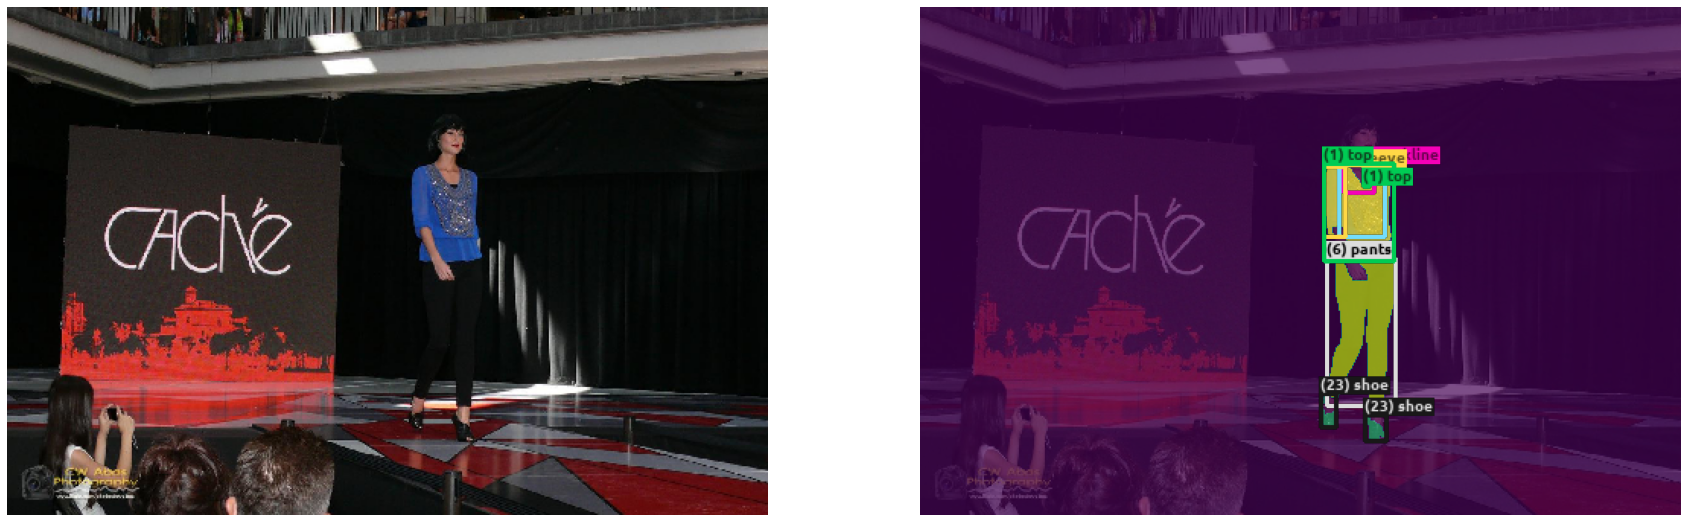

In [94]:
import worker
reload_external_packages()

max_dim = 500
font = bbx.get_font_with_size(10)

# generate a map from the class id to the label
def get_label(class_id):
    class_name = categories_df.loc[class_id]['name']
    label = class_name
    if ',' in class_name:
        label = class_name.split(',')[0]
    label = "(" + str(class_id) + ") " + label
    return label


def get_image_bounding_boxes(width, height, bounding_boxes, labels, decode_labels=True):
    image_with_bb = np.zeros((height, width, 3))
    image_with_bb = worker.rescale(image_with_bb, max_dim=max_dim)
    for box, class_id in zip(bounding_boxes, labels):
        class_id = class_id.cpu().numpy()
        bbx.add(image_with_bb, *box, label=(get_label(class_id) if decode_labels else str(class_id)), font=font)

    # creating the alpha channel for the bounding box image (to avoid obscuring the original image with black background)
    bb_alpha = np.array(np.max(image_with_bb[:,:,:] > 0, axis=2) > 0, dtype=int)
    bb_alpha = bb_alpha * 255
    image_with_bb = np.concatenate((image_with_bb, bb_alpha.reshape(bb_alpha.shape[0], bb_alpha.shape[1], 1)), axis=2)
    image_with_bb = np.array(image_with_bb, dtype=int)
    return image_with_bb


def remove_empty_masks(labels, masks, bounding_boxes):
    indices_to_keep = []  # empty array with 1 dim
    idx = 0
    for mask in masks:
        if torch.max(mask).cpu().numpy() == 1:
            indices_to_keep.append(idx)
        idx += 1

    indices_to_keep = torch.tensor(indices_to_keep)
    return labels[indices_to_keep], masks[indices_to_keep], bounding_boxes[indices_to_keep]


def show_bounding_boxes_from_df(image_id, figsize=(30, 30)):
    # Get the an image id given in the training set for visualization
    vis_df = train_df[train_df['ImageId'] == image_id]
    vis_df = vis_df.reset_index(drop=True)
    class_ids = worker.get_labels(vis_df)
    masks = worker.get_masks(vis_df, max_dim=max_dim, dtype=int)
    bounding_boxes = worker.get_bounding_boxes(masks)
    class_ids, masks, bounding_boxes = remove_empty_masks(class_ids, masks, bounding_boxes)
    show_bounding_boxes(class_ids, masks, bounding_boxes, figsize=figsize)

def show_bounding_boxes(class_ids, masks, bounding_boxes, figsize=(30, 30)):
    print(class_ids.shape)
    print(masks.shape)
    print(bounding_boxes.shape)
    width = masks[0].shape[1]
    height = masks[0].shape[0]
    image_with_bb = get_image_bounding_boxes(width, height, bounding_boxes, class_ids)
    
    # generate the segments mask with colors
    mask = np.zeros((height, width))
    mask = worker.rescale(mask, max_dim=max_dim)
    for i, (curr_mask, class_id) in enumerate(zip(masks, class_ids)):
        curr_mask = curr_mask.cpu()
        mask = np.where(curr_mask == 0, mask, curr_mask * (255 - 4 * class_id))

    img = mpimg.imread(main_folder_path + f'/Data/train/{image_id}.jpg')
    img = worker.rescale(img, max_dim=max_dim)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[1].imshow(img)
    ax[1].imshow(mask, alpha=0.7)
    ax[1].imshow(image_with_bb)
    ax[1].axis('off')
    plt.show()


# image_id = '000b3ec2c6eaffb491a5abb72c2e3e26'
image_id = '0066d8d66ec36bdb91592fdc4aa17ed9'
# image_id = '0065e8a9202794fe86c932275bf85366'
show_bounding_boxes_from_df(image_id)

In [65]:
a = torch.tensor([1,2,3,4,5,6,7,8])
b = torch.tensor([0,3,5])
a[b]

a = torch.empty(0, dtype=int)
a.cat(1)
print(a)

AttributeError: ignored

# Prepare the data


In [ ]:
from worker import worker


def dump_queue(queue):
    """
    Empties all pending items in a queue and returns them in a list.
    """
    result = []

    for i in iter(queue.get, 'STOP'):
        result.append(i)
    time.sleep(.1)
    return result

# consider other package than pickle to save the processed data to disk
# refer to https://stackoverflow.com/questions/28068872/memoryerror-with-pickle-in-python
# for pickle refer to https://stackoverflow.com/questions/17098654/how-to-store-a-dataframe-using-pandas
if __name__ == '__main__':
    image_ids = train_df['ImageId'].unique()
    num_of_cores = multiprocessing.cpu_count()
    num_of_cores = 2
    lock = Lock()
    global_counter = Value('i', 0)
    q = Queue()
    skipped_images = Queue()
    
    jobs = []
    image_ids = image_ids[1:20]
    for image_ids_set in np.array_split(image_ids, num_of_cores):
        p = Process(target=worker, args=(q,skipped_images,train_df,lock,global_counter,image_ids_set))
        p.daemon = True
        jobs.append(p)
        
    for p in jobs:
        p.start()
        
    while global_counter.value < len(image_ids):
        print(global_counter.value)
        time.sleep(2.0)

    arr = dump_queue(q)
    print(arr)
    
    skipped = dump_queue(skipped_images)
    print(skipped)
        
    for p in jobs:
        p.join()
        
    print('Done')

Process Process-1:
Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
TypeError: worker() missing 1 required positional argument: 'skipped_images'
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
TypeError: worker() missing 1 required positional argument: 'skipped_images'


0


KeyboardInterrupt: ignored

In [ ]:
import worker as worker

# reloads the package with changes
import importlib
importlib.reload(worker)

from pathlib import Path
processed_data_folder_path = main_folder_path + "/processed_data/"
Path(processed_data_folder_path).mkdir(parents=True, exist_ok=True)

image_ids = train_df['ImageId'].unique()
image_ids = image_ids[1:20]
lock = Lock()
global_counter = Value('i', 0)
skipped_images = Queue()
worker.worker(processed_data_folder_path, 0, image_ids, train_df, lock, global_counter, skipped_images)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


MemoryError: 

# Dataloader

In [73]:
import utils
import transforms as T
import worker
importlib.reload(worker)

# TODO(ofekp): remove this
limit_images = 100

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

class IMATDataset(BaseDataset):
    def __init__(self, data_df, transforms=None):
        self.transforms = transforms
        self.data_df = data_df
        self.image_ids_all = data_df['ImageId'].unique()
        self.image_ids = self.image_ids_all[0:limit_images]
        self.skipped_images = []
        # TODO: indices = torch.randperm(len(dataset)).tolist()
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        vis_df = self.data_df[self.data_df['ImageId'] == image_id]
        vis_df = vis_df.reset_index(drop=True)
        labels = worker.get_labels(vis_df)
        try:
            masks = worker.get_masks(vis_df, max_dim=max_dim)
            for mask in masks:
                assert not torch.any(torch.isnan(mask))
                assert len(a.nonzero()) == torch.sum(a)  # check only ones and zeros
        except Exception as e:
            self.skipped_images.append(image_id)
            print("ERROR: Skipped image with id [{}] due to an exception [{}]".format(image_id, e))
            return
        boxes = worker.get_bounding_boxes(masks)
        for box in boxes:
            assert not torch.any(torch.isnan(box))
        
        num_objs = len(labels)

        image_id_idx = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        labels, masks, boxes = remove_empty_masks(labels, masks, boxes)

        target = {}
        target["labels"] = labels
        target["masks"] = masks
        target["boxes"] = boxes
        target["image_id"] = image_id_idx
        target["area"] = area
        target["iscrowd"] = iscrowd

#         image = Image.open(img_path).convert("RGB")
        image = mpimg.imread(main_folder_path + f'/Data/train/{image_id}.jpg')
        image = worker.rescale(image, max_dim=max_dim)
        if self.transforms is not None:
            image, target = self.transforms(image, target)

        print('.'),  # no newline
        return image, target

    def __len__(self):
        return len(self.image_ids)

In [ ]:
dataset = IMATDataset(train_df, get_transform(train=True))
for d in dataset:
    print(d)
    print(d[0].shape)
    print(d[1]['boxes'].shape)
    print(d[1]['labels'].shape)
    print(d[1]['masks'].shape)
    print(d[1]['area'].shape)
    break
# split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])

.
(tensor([[[0.8157, 0.8157, 0.8157,  ..., 0.8157, 0.8157, 0.8157],
         [0.8157, 0.8157, 0.8157,  ..., 0.8157, 0.8157, 0.8157],
         [0.8157, 0.8157, 0.8157,  ..., 0.8157, 0.8157, 0.8157],
         ...,
         [0.8157, 0.8157, 0.8157,  ..., 0.8157, 0.8157, 0.8157],
         [0.8157, 0.8157, 0.8157,  ..., 0.8157, 0.8157, 0.8157],
         [0.8157, 0.8157, 0.8157,  ..., 0.8157, 0.8157, 0.8157]],

        [[0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196],
         [0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196],
         [0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196],
         ...,
         [0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196],
         [0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196],
         [0.8196, 0.8196, 0.8196,  ..., 0.8196, 0.8196, 0.8196]],

        [[0.7882, 0.7882, 0.7882,  ..., 0.7882, 0.7882, 0.7882],
         [0.7882, 0.7882, 0.7882,  ..., 0.7882, 0.7882, 0.7882],
         [0.7882, 0.7882, 0.7882,  ..., 0.7882, 0.7882,

# segmentation_models_pytorch

In [ ]:
!pip install -U segmentation_models_pytorch

import segmentation_models_pytorch as smp
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model = smp.Unet('efficientnet-b7', classes=num_classes, activation='softmax')

# replace the classifier with a new one, that has
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\ofekp/.cache\torch\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\ofekp/.cache\torch\checkpoints\mobilenet_v2-b0353104.pth


# Model

In [74]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256  # TODO(ofekp): was 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Optional

HERE 01


KeyError: 'masks'

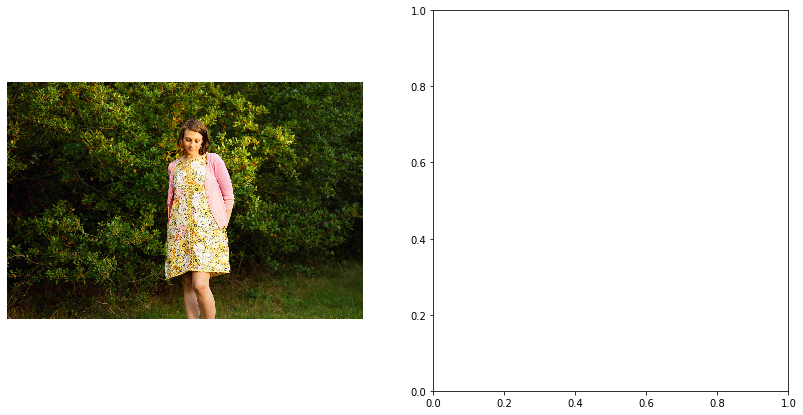

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = IMATDataset(train_df, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn) # TODO: num_workers was 4, but it caused an exception, refer to https://stackoverflow.com/questions/50480689/pytorch-torchvision-brokenpipeerror-errno-32-broken-pipe
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax[0].imshow(images[0].mul(255).permute(1, 2, 0).byte().cpu().numpy())
ax[0].axis('off')

# For inference
model.eval()
with torch.no_grad():
    predictions = model(images)           # Returns predictions

print("HERE 01")
ax[1].imshow(predictions[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
ax[1].axis('off')
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(images[0].size())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))
ax.imshow(images[0].mul(255).permute(1, 2, 0).byte().cpu().numpy())
ax.axis('off')
plt.show()

with torch.no_grad():
    predictions = model(images)
    
print(predictions)

NameError: name 'images' is not defined

# Train

In [75]:
import pycocotools
import worker
import coco_utils, coco_eval, engine, utils
importlib.reload(pycocotools)
importlib.reload(coco_utils)
importlib.reload(coco_eval)
importlib.reload(engine)
importlib.reload(utils)
# import torchvision.utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# use our dataset and defined transformations
dataset = IMATDataset(train_df, get_transform(train=True))
dataset_test = IMATDataset(test_df, get_transform(train=False))

# split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)  # TODO: num_workers was 4

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)  # TODO: num_workers was 4

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 4
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    engine.train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    engine.evaluate(model, data_loader_test, device=device)
    print("Epoch [{}/{}]".format(epoch + 1, num_epochs))
    file_name = 'code_ofek/Model/inst_seg_epoch{' + str(epoch) + '}.model'
    full_path = main_folder_path + file_name
    torch.save(model, full_path)
    print('Saved model to [{}]'.format(full_path))

print("That's it!")

.
Epoch: [0]  [  0/100]  eta: 0:01:22  lr: 0.000055  loss: 5.7627 (5.7627)  loss_classifier: 3.9661 (3.9661)  loss_box_reg: 0.2778 (0.2778)  loss_mask: 0.9262 (0.9262)  loss_objectness: 0.5263 (0.5263)  loss_rpn_box_reg: 0.0662 (0.0662)  time: 0.8283  data: 0.2601  max mem: 2324
.
.
.
.
.
.
.
.
.
.
Epoch: [0]  [ 10/100]  eta: 0:03:10  lr: 0.000560  loss: 5.7319 (6.0737)  loss_classifier: 3.2792 (3.0755)  loss_box_reg: 0.2778 (0.2556)  loss_mask: 0.9499 (0.9421)  loss_objectness: 0.5540 (1.3818)  loss_rpn_box_reg: 0.0914 (0.4186)  time: 2.1145  data: 1.6294  max mem: 2324
.
.
.
.
.
.
.
.
.
.
Epoch: [0]  [ 20/100]  eta: 0:02:55  lr: 0.001065  loss: 2.6482 (4.2679)  loss_classifier: 1.2173 (1.9869)  loss_box_reg: 0.2006 (0.2167)  loss_mask: 0.8073 (0.8600)  loss_objectness: 0.3954 (0.9294)  loss_rpn_box_reg: 0.0755 (0.2748)  time: 2.2675  data: 1.7869  max mem: 2324
.
.
.
.
.
.
.
.
.
.
Epoch: [0]  [ 30/100]  eta: 0:02:22  lr: 0.001569  loss: 1.9419 (3.4268)  loss_classifier: 0.6148 (1.509

AssertionError: ignored

In [ ]:
%tb

SystemExit: ignored

.


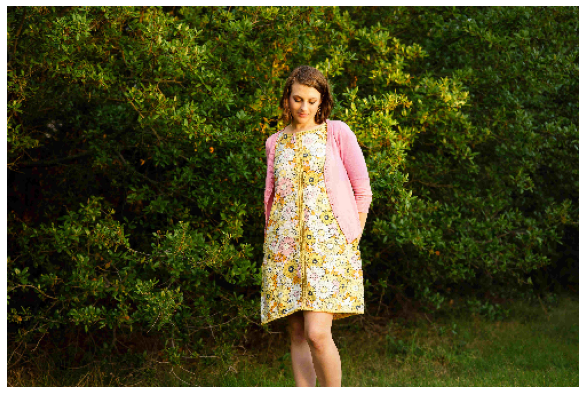

In [76]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#model = get_model_instance_segmentation(2)
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model.to(device)

# pick one image from the test set
# use our dataset and defined transformations
dataset = IMATDataset(train_df, get_transform(train=True))
dataset_test = IMATDataset(test_df, get_transform(train=False))
img, _ = dataset[8]  # TODO(ofekp): should take from 'dataset_test'
img = worker.rescale(img, max_dim=max_dim)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))
ax.imshow(img.mul(255).permute(1, 2, 0).byte().cpu().numpy())
ax.axis('off')
plt.show()
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [77]:
print(img.shape)
prediction

torch.Size([3, 333, 500])


[{'boxes': tensor([[277.8177,  89.1626, 314.9548, 193.9192],
          [294.0507,  89.2306, 321.2358, 210.4132],
          [194.4669, 101.4090, 317.0573, 262.9976],
          [230.5139,  49.9594, 307.1658, 245.3338],
          [219.8845,  78.4661, 285.1476, 302.8158],
          [247.6063, 100.3234, 280.3300, 125.3163],
          [240.9835, 267.1758, 297.6834, 330.2639],
          [273.6144, 120.8348, 308.2810, 214.1948],
          [239.1893, 104.6551, 283.2646, 112.1669],
          [242.7955, 255.0163, 289.7587, 331.4796],
          [225.9830, 107.4049, 236.5336, 191.9723],
          [272.9611,  53.0761, 323.9938, 264.0690],
          [284.5938, 105.0442, 325.1586, 173.5425],
          [231.3160,  53.8832, 314.8022, 261.2528],
          [224.0990,  91.4756, 241.9292, 281.7906],
          [239.2266, 107.1028, 279.6825, 115.1526],
          [261.0150, 266.2150, 294.1291, 331.6427],
          [244.2722, 102.2611, 282.3638, 109.7310],
          [233.5402,  95.4058, 323.1059, 206.0604],
   

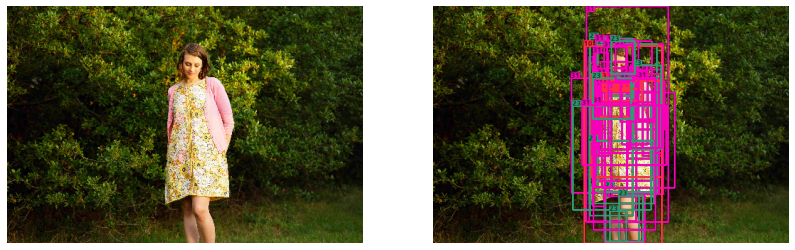

torch.Size([51, 4])
torch.Size([51])
torch.Size([51, 333, 500])
torch.Size([51])
torch.Size([51, 333, 500])
torch.Size([51, 4])


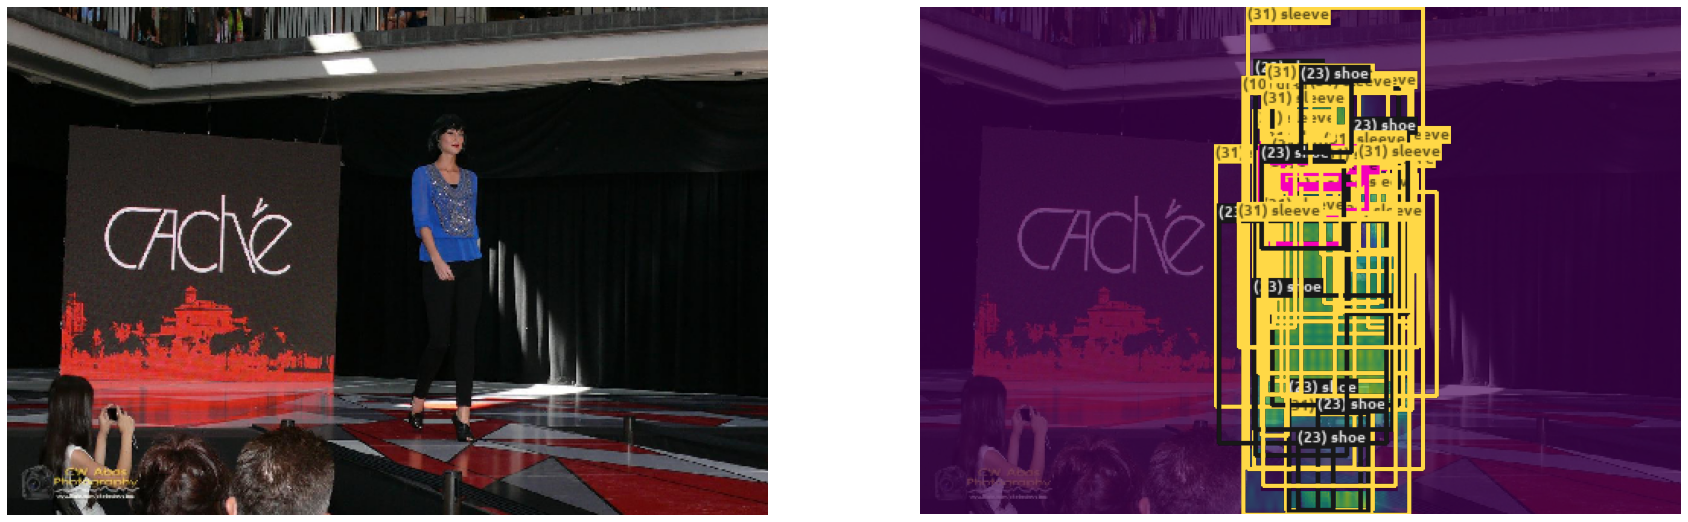

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
img_formatted = img.mul(255).permute(1, 2, 0).byte().cpu().numpy()
img_formatted = worker.rescale(img_formatted, max_dim=max_dim)
ax[0].imshow(img_formatted)
ax[0].axis('off')
# ax[1].imshow(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
width = img.size()[2]
height = img.size()[1]
boxes = [tuple(entry) for entry in prediction[0]['boxes']]
class_ids = prediction[0]['labels']
masks = prediction[0]['masks']
bbs_img = get_image_bounding_boxes(width, height, boxes, class_ids, decode_labels=False)
ax[1].imshow(img_formatted)
ax[1].imshow(bbs_img)
ax[1].axis('off')
plt.show()

# class_ids, masks, boxes = remove_empty_masks(class_ids, masks, boxes)
boxes = prediction[0]['boxes']
print(boxes.shape)
class_ids = prediction[0]['labels']
print(class_ids.shape)
masks = prediction[0]['masks'][:, 0]
print(masks.shape)
show_bounding_boxes(class_ids, masks, boxes)
    
# Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

# References

## Tier 1 - Actually relevant
- Processing the data - https://www.kaggle.com/kaushal2896/imaterialist-2020-starter-eda-mask-rcnn
- TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL - https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Tier 2 - Must reads (but did not read yet)
- Review: DeepMask (Instance Segmentation) - https://towardsdatascience.com/review-deepmask-instance-segmentation-30327a072339
- Semantic and Instance Segmentation on iOS Using a Flask API — DeepLabV3+ and Mask R-CNN - https://heartbeat.fritz.ai/semantic-and-instance-segmentation-on-ios-using-a-flask-api-deeplabv3-and-mask-r-cnn-b141213de3e7
- Guide to semantic segmentation - https://heartbeat.fritz.ai/a-2019-guide-to-semantic-segmentation-ca8242f5a7fc

## Tier 3 - To read or code helpers
- Current leading networks in segmentation - https://paperswithcode.com/task/instance-segmentation
- https://github.com/qubvel/segmentation_models.pytorch
- Guide to build Faster RCNN in PyTorch - https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439
- Faster R-CNN: Down the rabbit hole of modern object detection - https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/
- EfficientNet-PyTorch - https://github.com/lukemelas/EfficientNet-PyTorch/blob/master/examples/imagenet/main.py
- Continue videos from Stanford - https://www.youtube.com/watch?v=6wcs6szJWMY
- Mask RCNN video - https://www.youtube.com/watch?v=4tkgOzQ9yyo

## Code references/examples
- Passageway detection, as an example for usage in pretrained model - https://github.com/orhaim/Passageway_Detection

## Articles to read
- MaskRCNN - https://arxiv.org/pdf/1703.06870.pdf

## Read articles
- EfficientNets - https://arxiv.org/pdf/1905.11946.pdf

## TODOs
- [ ] Try to fix the IO error since the train folder is very big - https://research.google.com/colaboratory/faq.html#drive-timeout